# Importing libraries

In [ ]:
#importing various libraries and modules that are commonly used for data processing, visualization, data analysis, and model creation in Python.
#data processing
import numpy as np 
import pandas as pd
#visualization
import matplotlib.pyplot as plt 
import matplotlib as mpl 
from pylab import rcParams
import seaborn as sns 
#data analysis
from sklearn.model_selection import *
from sklearn.metrics import *
#data manipulation and model creation
from keras.layers import *
from keras.models import *



In [ ]:
#assigning the file path "./training/" to the variable `traindata` and the file name "labels_training.csv" to the variable `trainlabels`.
traindata="./training/"
trainlabels="labels_training.csv"

In [ ]:
pd.read_csv(trainlabels)

### The Label has two values:
* 0: No solar panel in the image
* 1: solar panel presented in the image

In [ ]:
# Load train data
def load_data(dir_data, dir_labels):
    """
    dir_data - the data or image directory
    dir_labels - respective CSV file with id and label related to the image data
    returns - it returns all the image and label in array format
    """
    labels_pd = pd.read_csv(dir_labels)
    ids = labels_pd.id.values
    data = []
    for identifier in ids:
        fname = dir_data + str(identifier) + ".tif"
        image = plt.imread(fname)
        data.append(image)

    data = np.array(data)
    labels = labels_pd.label.values
    return data, labels

In [ ]:
X, y = load_data(traindata, trainlabels)

In [ ]:
X

In [ ]:
y

In [ ]:
# Display the images with and without solar panels
plt.figure(figsize=(13, 8))  # Adjust the figure size
for i in range(6):  # For the first 6 images in the data
    plt.subplot(2, 3, i + 1)  # Create subplots
    plt.imshow(X[i])  # Show the respective image in the respective position
    if y[i] == 0:  # If label is 0
        title = 'No Solar Panels in this image'  # Set this as the title
    else:  # Else label is 1
        title = 'Solar Panels in this image'  # Set this as the title
    plt.title(title, color='r', weight='bold')  # Adding title to each image in the subplot
plt.tight_layout()  # Automatically adjusts the width and height between images in subplot
plt.show()  # Display the subplot


In [ ]:
X.shape
# total 1500 images
# image dimension is 101x101
# 3 is rgb  

In [ ]:
np.bincount(y)#binarycount
#995 images without solor panels
#505 with solar panels

In [ ]:
#scaling the value
X=X/255.0

## building cnn model 

In [ ]:

# Build model
def build_model():
    """
    RETURN keras model
    """
    image_height = 101
    image_width = 101
    image_channels = 3

    model = Sequential()
    # Layer - 1
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(image_height, image_width, image_channels)))
    model.add(BatchNormalization())
    # Layer - 2
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    # Layer - 3
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2))
    # Layer-4
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    # Layer-5
    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    # Layer-6
    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Cross-validation function
def crossvalid(x, y, num_folds, clf):
    """
    x - training data
    y - training label
    num_folds = number of folds for cross-validation
    clf = classifier to use
    """
    prediction_scores = np.empty(y.shape[0], dtype='object')
    kfolds = StratifiedKFold(n_splits=num_folds, shuffle=True)
    for train_index, val_index in kfolds.split(x, y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        class_weight = {0: 505 / 1500, 1: 995 / 1500}
        clf.fit(x=x_train, y=y_train, class_weight=class_weight, batch_size=15, epochs=25, shuffle=True, verbose=1,
                validation_data=(x_val, y_val))

        y_val_pred = clf.predict(x_val).reshape((-1,))
        prediction_scores[val_index] = y_val_pred

    return prediction_scores

In [68]:
num_folds = 3
cnn = build_model()
cnn.summary()
cnn_y_hat_pred = crossvalid(X, y, num_folds, cnn)
cnn.save("solar_panel_model.h5")00000000000


67/67 [==============================] - 67s 993ms/step - loss: 0.2471 - accuracy: 0.7360 - val_loss: 0.6417 - val_accuracy: 0.6640
Epoch 2/25
67/67 [==============================] - 64s 947ms/step - loss: 0.1886 - accuracy: 0.8290 - val_loss: 1.2703 - val_accuracy: 0.6640
Epoch 3/25
67/67 [==============================] - 67s 993ms/step - loss: 0.1644 - accuracy: 0.8460 - val_loss: 1.9071 - val_accuracy: 0.6640
Epoch 4/25
67/67 [==============================] - 65s 963ms/step - loss: 0.1666 - accuracy: 0.8410 - val_loss: 2.0726 - val_accuracy: 0.6640
Epoch 5/25
67/67 [==============================] - 67s 996ms/step - loss: 0.1546 - accuracy: 0.8510 - val_loss: 2.1307 - val_accuracy: 0.6640
Epoch 6/25
67/67 [==============================] - 66s 986ms/step - loss: 0.1484 - accuracy: 0.8760 - val_loss: 0.8386 - val_accuracy: 0.7220
Epoch 7/25
67/67 [==============================] - 64s 956ms/step - loss: 0.1132 - accuracy: 0.9030 - val_loss: 1.3509 - val_accuracy: 0.6640
Epoch 8/25

In [69]:
df = pd.read_csv(trainlabels)  # Create a data frame of labels
df["predicted_class"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_pred]  # Add a column for predicted class

# Get the values for FN, FP, TP, TN
fn = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 0)]['id'])  # False Negative
fp = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 1)]['id'])  # False Positive
tp = np.array(df[(df['label'] == 1) & (df['predicted_class'] == 1)]['id'])  # True Positive
tn = np.array(df[(df['label'] == 0) & (df['predicted_class'] == 0)]['id'])  # True Negative


In [70]:
def show_images(image_ids, num_images, title, color):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4  # Adjusting figure size
    plt.figure()  # Generating figure
    
    # Determine the number of images to display (in case num_images is greater than available images)
    num_to_display = min(num_images, len(image_ids))
    
    n = 1  # index where plot should appear in subplot
    for i in image_ids[0:num_to_display]:  # Run a loop for the total number of images to display
        plt.subplot(1, num_to_display, n)  # Generate a subplot
        plt.imshow(X[i, :, :, :])  # Display the image
        plt.title('Image id: ' + str(i))  # Add title
        plt.axis('off')  # Turn off the axis
        n += 1  # Incrementing index by 1

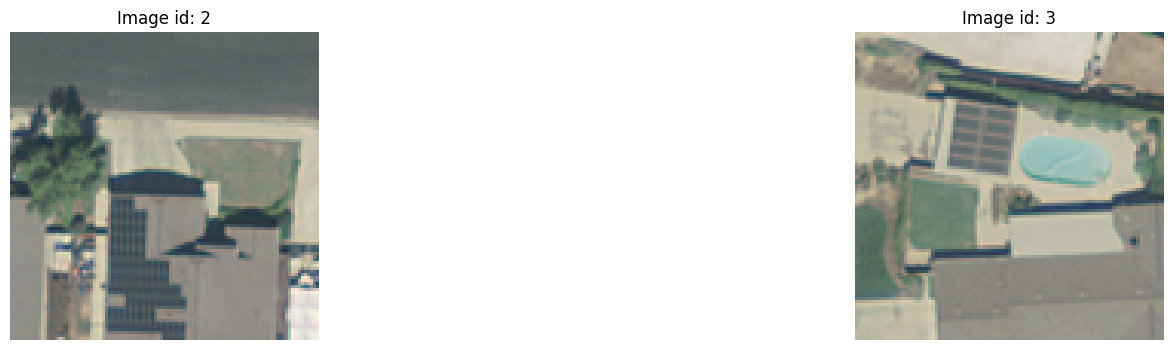

In [71]:
num_images = 2  # number of images to look at

# Examples of True Positives
show_images(tp, num_images, 'Examples of True Positives - Predicted solar panels if they were present', 'g')


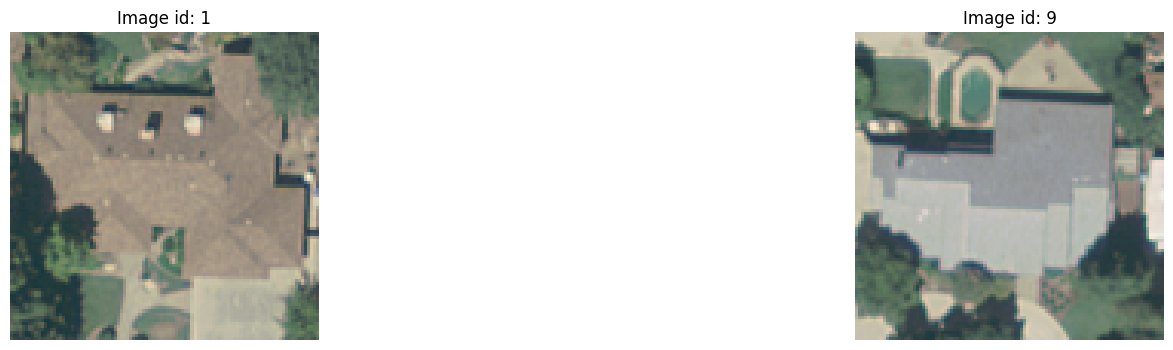

In [72]:

# Examples of False Positives
show_images(fp, num_images, 'Examples of False Positives - Predicted solar panels even if they were not present', 'r')


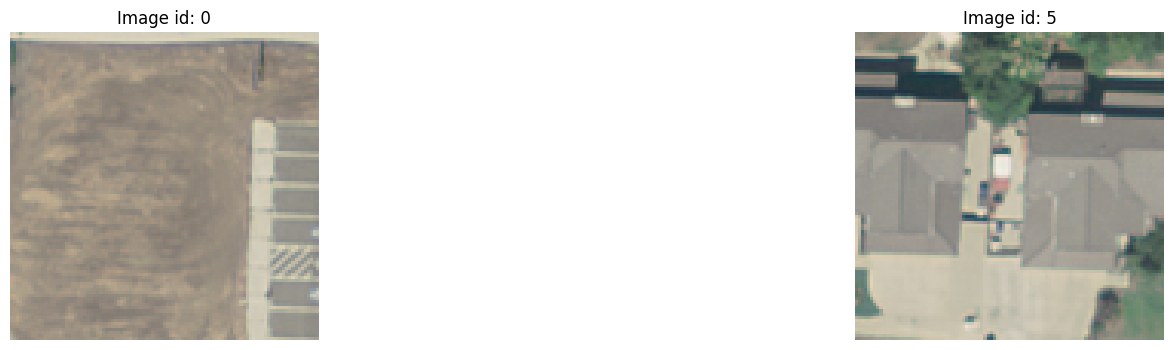

In [73]:

# Examples of True Negatives
show_images(tn, num_images, 'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')


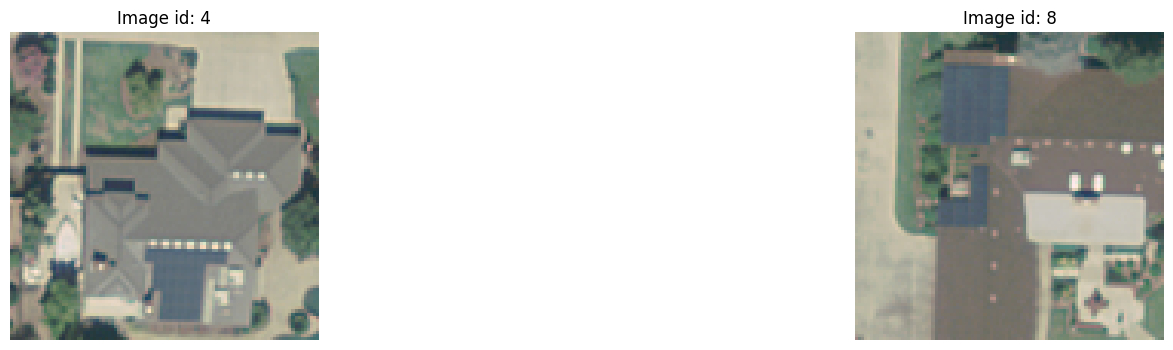

In [74]:

# Examples of False Negatives
show_images(fn, num_images, 'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')


In [75]:
# ROC - AUC
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

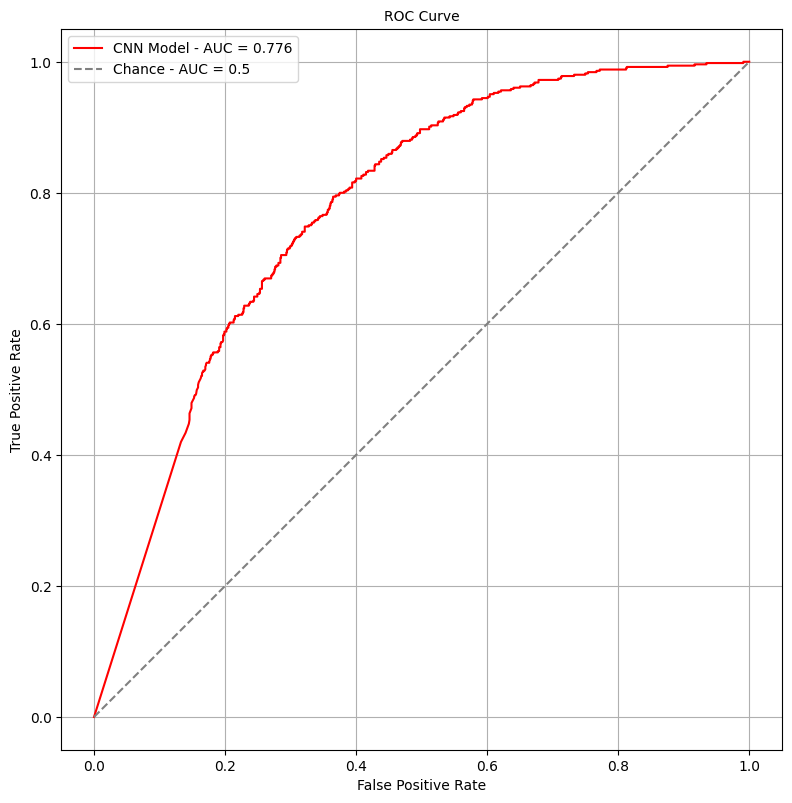

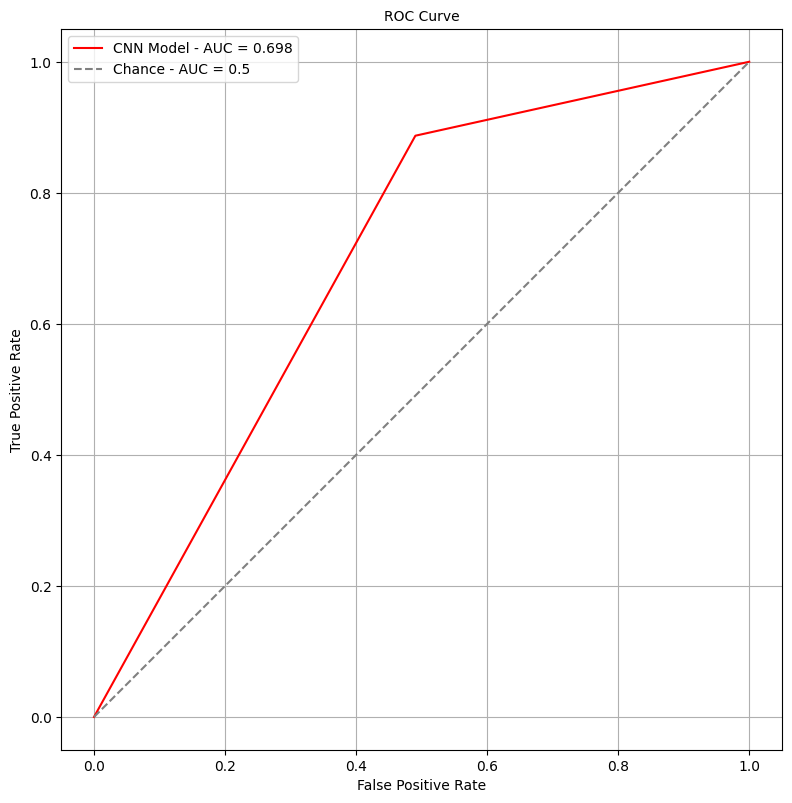

In [76]:

# Assuming you have defined cnn_y_hat_prob
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_pred]
plot_roc(y, cnn_y_hat_pred)
plot_roc(y, y_pred)


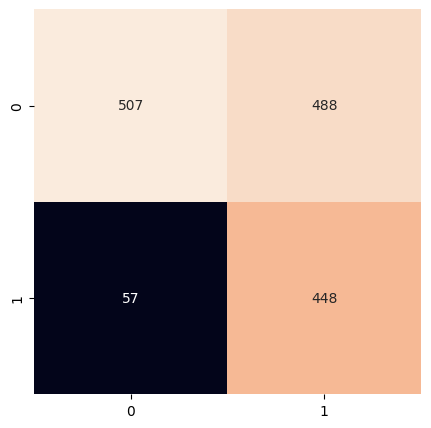

In [77]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()